<a href="https://colab.research.google.com/github/ztjfreedom/colab/blob/master/keras_rnn_attention_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, We build text classification models in Keras that use attention mechanism to provide insight into how classification decisions are being made.

## Prepare Dataset
We’ll use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. The IMDB dataset comes packaged with Keras. It has already been preprocessed such that the sequences of words have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

In [0]:
%matplotlib inline
import os
import tensorflow as tf
import keras.backend as K
from keras_preprocessing import sequence
from keras.layers import *
from keras.models import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [0]:
vocab_size = 10000
 
pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2
 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size, start_char=start_id,
                                                                        oov_char=oov_id, index_from=index_offset)
 
word2idx = tf.keras.datasets.imdb.get_word_index()
 
print('Min index in word2idx:', min(word2idx.items(), key=lambda item: item[1]))

Keras provide function pad_sequences takes care padding sequences. We only have to give it the max_len argument which will determine the length of the output arrays. If sentences are shorter than this length, they will be padded and if they are longer, they will be trimmed.

In [3]:
word2idx = {k: v + index_offset for k, v in word2idx.items()}
idx2word = {v: k for k, v in word2idx.items()}
 
idx2word[pad_id] = '<PAD>'
idx2word[start_id] = '<START>'
idx2word[oov_id] = '<OOV>'
 
max_len = 80
rnn_cell_size = 128
 
x_train = sequence.pad_sequences(x_train,
                                 maxlen=max_len,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
x_test = sequence.pad_sequences(x_test, 
                                maxlen=max_len,
                                truncating='post',
                                padding='post',
                                value=pad_id)

print('Review at word2idx:')
print('word the:', word2idx['the'])

print('Review at idx2word:')
print('idx 0:', idx2word[0])
print('idx 1:', idx2word[1])
print('idx 2:', idx2word[2])
print('idx 3:', idx2word[3])

Review at word2idx:
word the: 3
Review at idx2word:
idx 0: <PAD>
idx 1: <START>
idx 2: <OOV>
idx 3: the


## Pre-trained GLoVe

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/dataset/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/dataset


In [5]:
# Parsing GLoVE word embedding files
glove_dict = {}
with open(os.path.join('glove', 'glove.6B.50d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = coefs


print('Found %s word vectors.' % len(glove_dict))

for key in glove_dict.keys():
    print('Frist key:', key)
    break

Found 400000 word vectors.
Frist key: the


In [6]:
# 0 is used for padding, so we set it to all zeros
embedding_matrix = np.random.normal(loc=0.0, scale=1.0, size=(vocab_size, 50))
embedding_matrix[0] = np.zeros(50)
for word, i in word2idx.items():
    if i < 10000:
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print('Embedding review:')
print(embedding_matrix.shape)
print(embedding_matrix[0])
print(embedding_matrix[1])
print(embedding_matrix[3])
print(glove_dict['the'])

Embedding review:
(10000, 50)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 1.42576577 -1.74478284 -0.64736253  0.26380198 -0.46950615  0.04085707
 -1.00885976  1.45821201 -1.06941491 -1.02752209 -0.63001538 -1.55715559
 -0.58781136 -0.16534477 -0.22280624 -0.92582924  0.63208453  0.67441906
  1.1971006   1.90387458 -1.94896777 -0.8279956   1.06974494 -0.55934359
  1.18077087  0.17849756  1.36668251  0.14156975 -0.66128088  1.30115542
 -1.43224451  1.35921625 -0.66289783  0.28906809 -0.80765559 -0.1648786
 -0.18261234 -0.36393716  1.21956617  0.52869823  2.4136912  -0.45797747
  0.11586065 -0.55238252  0.47984307  0.65838836 -0.23103201 -1.21848454
  1.27952061 -0.39359994]
[ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027

## Attention mechanism in Keras
Referring to https://github.com/philipperemy/keras-attention-mechanism

The following 2 code blocks are used for example


In [0]:
INPUT_DIM = 32

def build_model_dense():
    inputs = Input(shape=(INPUT_DIM,))

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(INPUT_DIM, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

In [0]:
INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
    return output_attention_mul


def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

## Modeling

In [0]:
def attention_3d_block(inputs, time_steps, single_attention_vector):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, time_steps))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
    return output_attention_mul

In [13]:
# attention before LSTM
inputs = Input(shape=[max_len], dtype='int32')
embedded = Embedding(input_dim=vocab_size, output_dim=50, input_length=max_len)(inputs)
attention_mul = attention_3d_block(embedded, max_len, False)  # attention here
embedded = Dropout(rate=0.5)(embedded)
activations = Bidirectional(CuDNNLSTM(128))(attention_mul)
output = Dense(1, activation='sigmoid')(activations)
model = Model(input=[inputs], output=output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  import sys


In [24]:
# attention after LSTM
inputs = Input(shape=[max_len], dtype='int32')
embedded = Embedding(input_dim=vocab_size, output_dim=50, input_length=max_len)(inputs)
embedded = Dropout(rate=0.5)(embedded)
activations = Bidirectional(CuDNNLSTM(128, return_sequences=True))(embedded)
attention_mul = attention_3d_block(activations, max_len, False)  # attention here
attention_mul = Flatten()(attention_mul)
output = Dense(1, activation='sigmoid')(attention_mul)
model = Model(input=[inputs], output=output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [0]:
# freeze embeddings
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 80, 50)       500000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 80, 50)       0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 80, 256)      184320      dropout_3[0][0]                  
__________________________________________________________________________________________________
permute_3 

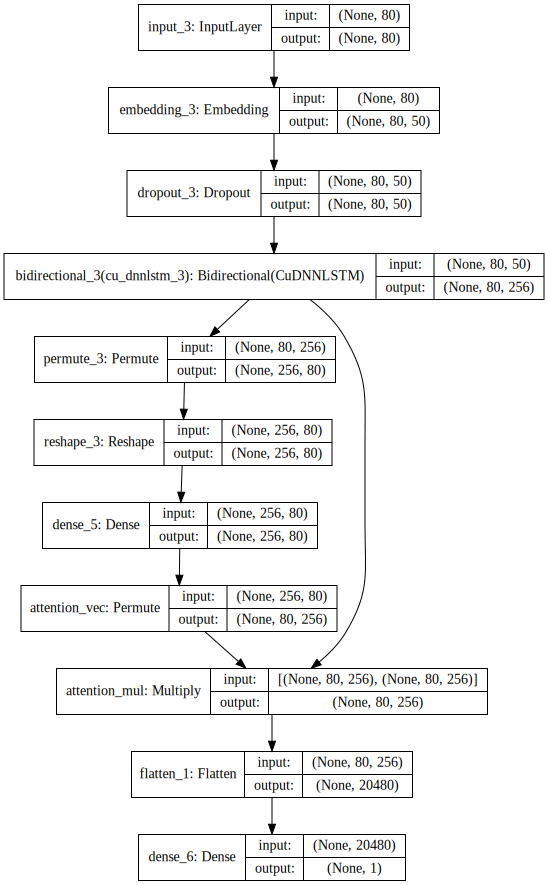

In [27]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 4.Training

In [28]:
%%time
epochs = 20
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 4s 212us/step - loss: 0.6445 - acc: 0.6235 - val_loss: 0.6874 - val_acc: 0.6314
Epoch 2/20
20000/20000 [==============================] - 3s 168us/step - loss: 0.5985 - acc: 0.6811 - val_loss: 0.5751 - val_acc: 0.6944
Epoch 3/20
20000/20000 [==============================] - 3s 169us/step - loss: 0.5756 - acc: 0.6996 - val_loss: 0.5373 - val_acc: 0.7352
Epoch 4/20
20000/20000 [==============================] - 3s 169us/step - loss: 0.5582 - acc: 0.7111 - val_loss: 0.5529 - val_acc: 0.7110
Epoch 5/20
20000/20000 [==============================] - 3s 170us/step - loss: 0.5456 - acc: 0.7210 - val_loss: 0.4965 - val_acc: 0.7600
Epoch 6/20
20000/20000 [==============================] - 3s 170us/step - loss: 0.5345 - acc: 0.7294 - val_loss: 0.5146 - val_acc: 0.7346
Epoch 7/20
20000/20000 [==============================] - 3s 171us/step - loss: 0.5259 - acc: 0.7323 - val_loss: 0.4784 - v

In [29]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 78.15%


## Attention visualization

In [0]:
def get_activations(model, inputs, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    if layer_name is None:
        layers = [layer.output for layer in model.layers]
    else:
        layers = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    
    funcs = [K.function([model.input, K.learning_phase()], [layer]) for layer in layers]  # evaluation functions
    
    layer_outputs = [func([inputs, 1]) for func in funcs]
    
    print(len(layer_outputs), len(layer_outputs[0]), layer_outputs[0][0].shape)
    
    return layer_outputs[0][0][0]

In [34]:
sample = x_train[1]
label = y_train[1]

inputs = np.expand_dims(sample, axis=0)

print('inputs data shape:', inputs.shape)

activations = get_activations(model, inputs, layer_name='attention_vec')

print(activations.shape)

attention_vector = np.mean(activations, axis=1).squeeze()
print('attention:')
print(attention_vector)

assert (np.sum(attention_vector) - 1.0) < 1e-5

inputs data shape: (1, 80)
----- activations -----
1 1 (1, 80, 256)
(80, 256)
attention:
[0.00530922 0.01043579 0.00995418 0.00618045 0.00914546 0.01151391
 0.00694041 0.01258886 0.01803346 0.01091918 0.0363     0.00979462
 0.00846224 0.04192033 0.01101389 0.04685474 0.00841259 0.00752609
 0.01988479 0.00586914 0.00683325 0.00747261 0.01853474 0.00722614
 0.00604562 0.00711644 0.0058468  0.00753283 0.01179648 0.01150804
 0.00824825 0.00841381 0.00866597 0.00771399 0.0076501  0.00643135
 0.00533645 0.0098714  0.01319305 0.00780491 0.03347264 0.00708629
 0.01127074 0.00549441 0.00851036 0.00654391 0.00986857 0.00806192
 0.00624472 0.03274516 0.02570172 0.08882745 0.02267882 0.00595991
 0.00948961 0.01834263 0.01060998 0.00587359 0.00685671 0.00639419
 0.00674211 0.00714854 0.02199705 0.00728312 0.0103486  0.01574499
 0.008606   0.01583651 0.00678484 0.00785065 0.00932697 0.00629636
 0.0085499  0.01049377 0.00782604 0.00776382 0.00700607 0.01111082
 0.01057423 0.01237469]


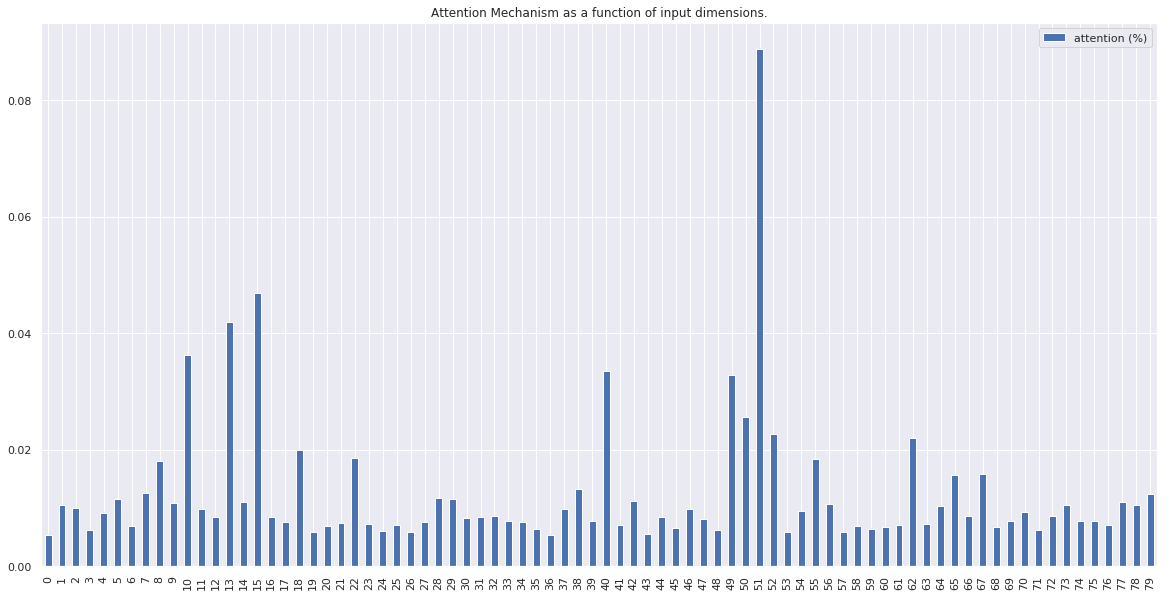

In [35]:
pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar', title='Attention Mechanism as a function of input dimensions.', figsize=(20, 10))
plt.show()

In [36]:
words = [(i, idx2word[index]) for i, index in enumerate(sample)]
print(words)
print(label)

[(0, '<START>'), (1, 'big'), (2, 'hair'), (3, 'big'), (4, 'boobs'), (5, 'bad'), (6, 'music'), (7, 'and'), (8, 'a'), (9, 'giant'), (10, 'safety'), (11, 'pin'), (12, 'these'), (13, 'are'), (14, 'the'), (15, 'words'), (16, 'to'), (17, 'best'), (18, 'describe'), (19, 'this'), (20, 'terrible'), (21, 'movie'), (22, 'i'), (23, 'love'), (24, 'cheesy'), (25, 'horror'), (26, 'movies'), (27, 'and'), (28, "i've"), (29, 'seen'), (30, 'hundreds'), (31, 'but'), (32, 'this'), (33, 'had'), (34, 'got'), (35, 'to'), (36, 'be'), (37, 'on'), (38, 'of'), (39, 'the'), (40, 'worst'), (41, 'ever'), (42, 'made'), (43, 'the'), (44, 'plot'), (45, 'is'), (46, 'paper'), (47, 'thin'), (48, 'and'), (49, 'ridiculous'), (50, 'the'), (51, 'acting'), (52, 'is'), (53, 'an'), (54, 'abomination'), (55, 'the'), (56, 'script'), (57, 'is'), (58, 'completely'), (59, 'laughable'), (60, 'the'), (61, 'best'), (62, 'is'), (63, 'the'), (64, 'end'), (65, 'showdown'), (66, 'with'), (67, 'the'), (68, 'cop'), (69, 'and'), (70, 'how'), (